# Data

In [14]:
import os 
import pandas as pd 
import itertools
import re
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [4]:
def preprocess(data, info):
    a = data.copy()
    info = re.findall(r".*(?=.csv)",info)[0]
    a = a.rename(columns={"First Tooltip": info})

    """    
    if ("Dim1" in a.columns.values):
        a['Both sexes'] = (a['Dim1'] == "Both sexes").replace({False:0, True:1})
        a['Male'] = (a['Dim1'] == "Male").replace({False:0, True:1})
        a['Female'] = (a['Dim1'] == "Female").replace({False:0, True:1})
    else:
        a['Both sexes'] = (a['Location'] != "Both sexes").replace({False:0, True:1})
        a['Male'] = (a['Location'] != "Male").replace({False:0, True:1})
        a['Female'] = (a['Location'] != "Female").replace({False:0, True:1})
    """

     
    data_2015 = a[a["Period"] == 2015]
    
    data_2016 = a[a["Period"] == 2016]
    
    data_2017 = a[a["Period"] == 2017]
    
    data_2018 = a[a["Period"] == 2018]
    
    data_2019 = a[a["Period"] == 2019]
    
    data_2020 = a[a["Period"] == 2020]
    
    data_2021 = a[a["Period"] == 2021]

    year_dic = {'2015':data_2015,'2016':data_2016,'2017':data_2017,'2018':data_2018,
                '2019':data_2019,'2020':data_2020,'2021':data_2021}
    
    if("Dim1" in a.columns.values):
        for key,df in year_dic.items():
            temp = df.groupby("Location").mean()
            temp.reset_index(inplace=True)
            temp = temp.loc[:, ['Location', info]]
            year_dic[key] = temp
    
    else:
        for key,df in year_dic.items():
            temp = df.loc[:, ['Location', info]]
            year_dic[key] = temp
    return year_dic


In [6]:
def merge_dic(data_lst):
    year_lst = [str(i) for i in range(2015,2022)]
    result = []
    for year in year_lst:
        temp = None
        indicator = False
        for variable_dict in data_lst: 
            if indicator == False:
                temp = variable_dict[year]
                indicator = True
            else:          
                temp = pd.merge(temp, variable_dict[year], on = ["Location"])
        temp['Period'] = np.array([year]*temp.shape[0])
        result.append(temp)
    return result

In [7]:
def read_data():
    data_lst = []

    for info in os.listdir("train_data"): 

        if info == ".DS_Store":
            continue
        domain = os.path.abspath(r"train_data")
        dirc = os.path.join(domain,info)
        data = pd.read_csv(dirc)
        
        data_lst.append([data, info])
    return data_lst


In [8]:
def run_proprocess(data_lst):
    result = []
    for [data, info] in data_lst:
        temp = preprocess(data, info)
        result.append(temp)
    return result

In [9]:
def main():
    raw_data = read_data()
    #[how many dataset uses, how many useful data]
    test = []
    
    #dataset (doesn't merge)
    comb = []
    
    #dataset merge
    result_lst = []
    for L in range(0, len(raw_data)+1):
        for subset in itertools.combinations(raw_data, L):
            if(len(subset) != 0):
                data_lst = subset
                data_lst = run_proprocess(data_lst)
                result = merge_dic(data_lst)
                count = 0
                for i in result:
                    count += i.shape[0]

                test.append([len(subset), count])

                temp = pd.DataFrame()
                for i in range(len(result)):
                    temp = pd.concat([temp, result[i]])
                
                
                result_lst.append(temp)
                comb.append(subset)
                
                
                
    return [test,comb,result_lst]


In [10]:
#don't run it if there are more than 15 datasets in train
[test, comb, result] = main()


In [11]:
happiness_score = pd.DataFrame()
for info in os.listdir("world-happiness-report"): 
    print(info)
    if info == ".DS_Store":
        continue
    domain = os.path.abspath(r"world-happiness-report")
    dirc = os.path.join(domain,info)
    data = pd.read_csv(dirc)
    data = data[['Country', 'Happiness Score']]
    info = re.findall(r".*(?=.csv)",info)[0]
    data["Period"] = np.array([info]*data.shape[0])
    data = data.rename(columns={"Country": "Location"})
    happiness_score = pd.concat([happiness_score, data])


.DS_Store
2020.csv
2021.csv
2019.csv
2018.csv
2015.csv
2016.csv
2017.csv


In [12]:
out_all_data = result[-1]
out_all_data = pd.merge(out_all_data, happiness_score, on = ["Location", "Period"])
out_dirc = "all_data.csv"
out_all_data.to_csv(out_dirc,sep=',',index=True,header=True)


In [15]:
#[[mse, r2], subset]
model_lst = []

# use subset to train the model
for subset in result:
    all_data = subset
    all_data = pd.merge(all_data, happiness_score, on = ["Location", "Period"])
    data = all_data.loc[:, (all_data.columns != 'Location') 
                        & (all_data.columns != 'Happiness Score') 
                        & (all_data.columns != 'Period')].values
    target = all_data["Happiness Score"].values
    train_data, test_data, train_target, test_target = train_test_split(data, target, 
                                                                test_size=0.25, 
                                                                random_state=216)

    linear_model = LinearRegression()
    linear_model.fit(X=train_data, y=train_target)

    predict = linear_model.predict(test_data)

    mse = mean_squared_error(test_target, predict)
    r2 = r2_score(test_target, predict)
    
    
    model_lst.append([[mse, r2], subset])

In [16]:
model_lst = sorted(model_lst, key=lambda x:float(x[0][1]), reverse = True)
model_lst

[[[0.26102526983377766, 0.7617113815918095],
                                               Location  \
  0                                             Albania   
  1                                             Algeria   
  2                                             Armenia   
  3                                           Australia   
  4                                             Austria   
  ..                                                ...   
  77                               United Arab Emirates   
  78  United Kingdom of Great Britain and Northern I...   
  79                        United Republic of Tanzania   
  80                                              Yemen   
  81                                           Zimbabwe   
  
      HALElifeExpectancyAtBirth  nursingAndMidwife  30-70cancerChdEtc  \
  0                   68.708364          41.464070          17.285104   
  1                   66.125415          14.596696          14.317035   
  2                   65.

# EDA

In [45]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

In [20]:
data = all_data[all_data.columns.difference(['Location', 'Period', 
                                             'Happiness Score'])]
data.insert(0,'Happiness Score',all_data['Happiness Score'])
data

Happiness Score  30-70cancerChdEtc  HALElifeExpectancyAtBirth  \
0             4.350          23.443990                  65.925275   
1             5.212          22.741715                  62.985302   
2             4.694          21.696621                  63.324665   
3             4.194          27.961123                  62.198928   
4             4.565          23.406015                  59.122753   
..              ...                ...                        ...   
92            4.759          21.685080                  54.796274   
93            5.840          12.341262                  69.943181   
94            5.880          24.469569                  62.063904   
95            5.132          14.968784                  59.573890   
96            3.658          29.168455                  56.636244   

    alcoholSubstanceAbuse  atLeastBasicSanitizationServices  \
0                6.058881                         91.525044   
1                3.907791                         91.088383   
2                0.054347                         46.402625   
3                0.376354                         94.298550   
4                5.086731                         56.893254   
..                    ...                               ...   
92              10.104531                         42.198520   
93               5.503568                         72.804827   
94               7.059378                         83.000230   
95               0.894335                         54.343056   
96               0.124719                         66.564103   

    basicDrinkingWaterServices  basicHandWashing  \
0                    99.416965         91.908775   
1                    79.457117         83.240000   
2                    96.439530         37.070783   
3                    98.567802         88.350527   
4                    88.907932         62.792857   
..                         ...               ...   
92                   60.588702         42.259762   
93                   81.270973         55.510000   
94                   92.582503         78.771667   
95                   78.384861         25.086286   
96                   65.284422         52.932831   

    birthAttendedBySkilledPersonal  cleanFuelAndTech  crudeSuicideRates  ...  \
0                        99.839461         95.667404           3.732826  ...   
1                        99.825077         95.588589           1.507180  ...   
2                        46.170013         18.134985           3.264752  ...   
3                        94.014815         95.436444           1.988404  ...   
4                        80.973713         43.234498           8.982969  ...   
..                             ...               ...                ...  ...   
92                       41.428325         10.593012          -4.381125  ...   
93                       92.579545         82.841486          -1.450707  ...   
94                       93.037796         47.235825          -1.248138  ...   
95                       81.633223         13.032198          -4.455857  ...   
96                      235.271429         60.354976          -4.936733  ...   

    incedenceOfMalaria  interventionAgianstNTDs  lifeExpectancyAtBirth  \
0            -0.001650             3.908744e+04              74.416390   
1            -0.246159             1.404202e+06              70.550045   
2             2.415014             5.677979e+07              72.997370   
3             0.000000             8.239580e+06              70.807829   
4             9.726742             7.014165e+08              69.368598   
..                 ...                      ...                    ...   
92          194.366378             9.588918e+07              63.152383   
93            7.796663            -1.612728e+06              80.548464   
94           -0.622404             5.769294e+07              70.531431   
95          105.157380             5.710917e+06              68.745446   
96           40.18

In [42]:
data_rename = data.copy()
data_rename.columns = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 
                       'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 
                       'S', 'T', 'U']
data_rename

A          B          C          D          E          F          G  \
0   4.350  23.443990  65.925275   6.058881  91.525044  99.416965  91.908775   
1   5.212  22.741715  62.985302   3.907791  91.088383  79.457117  83.240000   
2   4.694  21.696621  63.324665   0.054347  46.402625  96.439530  37.070783   
3   4.194  27.961123  62.198928   0.376354  94.298550  98.567802  88.350527   
4   4.565  23.406015  59.122753   5.086731  56.893254  88.907932  62.792857   
..    ...        ...        ...        ...        ...        ...        ...   
92  4.759  21.685080  54.796274  10.104531  42.198520  60.588702  42.259762   
93  5.840  12.341262  69.943181   5.503568  72.804827  81.270973  55.510000   
94  5.880  24.469569  62.063904   7.059378  83.000230  92.582503  78.771667   
95  5.132  14.968784  59.573890   0.894335  54.343056  78.384861  25.086286   
96  3.658  29.168455  56.636244   0.124719  66.564103  65.284422  52.932831   

             H          I         J  ...           L             M          N  \
0    99.839461  95.667404  3.732826  ...   -0.001650  3.908744e+04  74.416390   
1    99.825077  95.588589  1.507180  ...   -0.246159  1.404202e+06  70.550045   
2    46.170013  18.134985  3.264752  ...    2.415014  5.677979e+07  72.997370   
3    94.014815  95.436444  1.988404  ...    0.000000  8.239580e+06  70.807829   
4    80.973713  43.234498  8.982969  ...    9.726742  7.014165e+08  69.368598   
..         ...        ...       ...  ...         ...           ...        ...   
92   41.428325  10.593012 -4.381125  ...  194.366378  9.588918e+07  63.152383   
93   92.579545  82.841486 -1.450707  ...    7.796663 -1.612728e+06  80.548464   
94   93.037796  47.235825 -1.248138  ...   -0.622404  5.769294e+07  70.531431   
95   81.633223  13.032198 -4.455857  ...  105.157380  5.710917e+06  68.745446   
96  235.271429  60.354976 -4.936733  ...   40.185452  8.490118e+06  65.655994   

            O         P          Q          R          S          T          U  
0   34.087895  0.662850  54.851575   0.531213  17.425441  46.843451  27.965383  
1   35.260026  0.590767  68.430130   1.912130  26.507333  91.695543  20.671537  
2    4.860637  0.320485   2.645873   1.110122  21.426594  29.991407  40.593523  
3    9.575396  0.223699  19.714545   3.788857  39.672455  64.541314  21.280227  
4    7.527041  2.428078  14.493428   6.422302  17.591980  34.278119  29.599135  
..        ...       ...        ...        ...        ...        ...        ...  
92   3.528251  2.111262  15.393317   1.339179  15.527143  26.925849   4.543779  
93  11.197427  0.918054  18.160666  23.698000   6.303848  56.227770   8.710546  
94   1.371930  0.203342  50.604448   0.199478   9.155000  55.721497  22.908449  
95  -1.555636  1.906841 -11.732320  -0.354990  12.005556  24.604750   8.455103  
96   7.862037  3.659592   7.011792   1.916958   7.157407  66.251791  19.904176  

[97 rows x 21 columns]

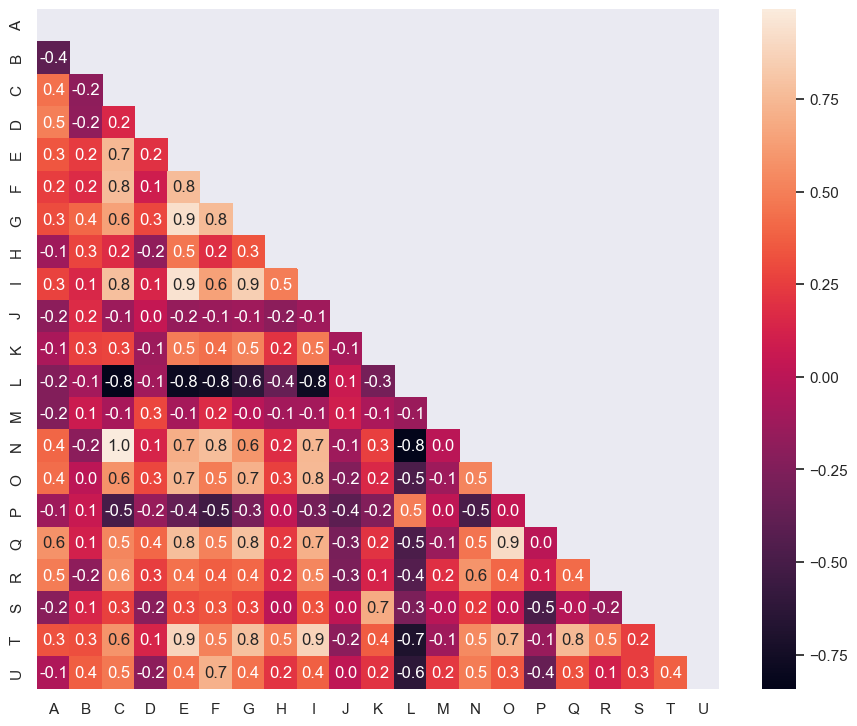

In [54]:
# correlation matrix
dcorr = data_rename.corr()
# correlation heatmap
plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data=dcorr, annot=True, fmt=".1f",
           mask=np.triu(np.ones_like(dcorr,dtype=np.bool)))
plt.savefig('heatmap.png')

<Figure size 1100x900 with 0 Axes>

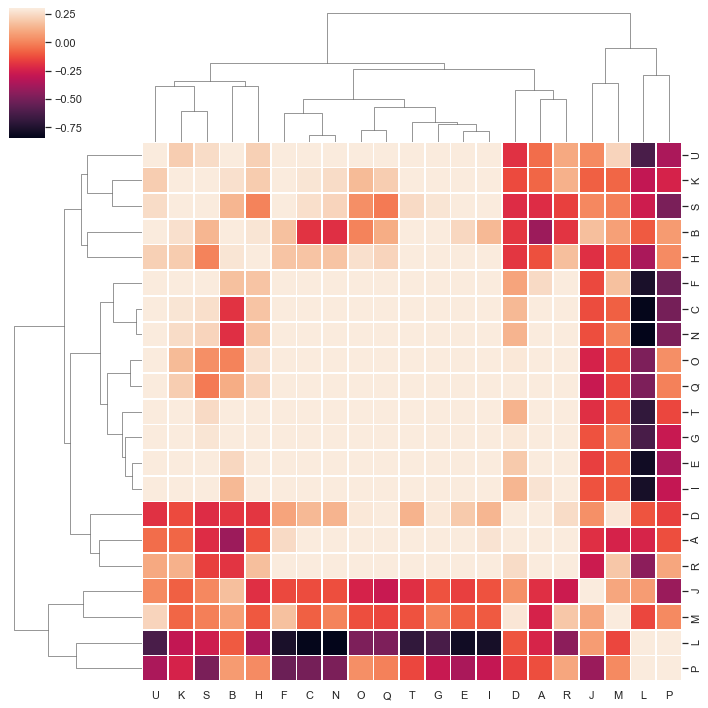

In [55]:
# 做着玩的
# correlation clustermap
plt.figure(figsize=(11, 9),dpi=100)
sns.clustermap(data=dcorr,
               vmax=0.3,
               #cmap=palettable.cmocean.diverging.Curl_10.mpl_colors,
               linewidths=.75)
plt.savefig('clustermap.png')